## 1

### 1.1

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# 读取 Excel 文件
df = pd.read_excel('dprime计算.xlsx')

# 初始化存储每个被试各项指标的列表
results = []

# 遍历所有被试
for subj in df['Subject'].unique():
    subj_data = df[df['Subject'] == subj]
    
    # 根据 zsfykp.CRESP 区分试次类型（全部转换为小写处理）
    # "f" 表示目标试次；"j" 表示非目标试次
    target_trials = subj_data[subj_data['zsfykp.CRESP'].str.lower() == 'f']
    non_target_trials = subj_data[subj_data['zsfykp.CRESP'].str.lower() == 'j']
    
    # 计算目标和非目标试次总数
    N_target = len(target_trials)
    N_nontarget = len(non_target_trials)
    
    # 如果某一类型试次数量为0，则 d' 不能计算，记录为 NaN
    if N_target == 0 or N_nontarget == 0:
        results.append({
            'Subject': subj,
            "d'": np.nan,
            'Hit Rate': np.nan,
            'False Alarm Rate': np.nan,
            'Hits': np.nan,
            'False Alarms': np.nan,
            'N_target': N_target,
            'N_nontarget': N_nontarget
        })
        continue

    # 在目标试次中，ACC==1 表示命中
    hits = target_trials[target_trials['zsfykp.ACC'] == 1].shape[0]
    # 在非目标试次中，ACC==0 表示错误报警
    false_alarms = non_target_trials[non_target_trials['zsfykp.ACC'] == 0].shape[0]
    
    # 计算命中率和错误报警率
    hit_rate = hits / N_target
    fa_rate = false_alarms / N_nontarget

    # 修正极端值：如果命中率为1或0，或者错误报警率为1或0
    if hit_rate == 1:
        hit_rate = 1 - 1/(2*N_target)
    if hit_rate == 0:
        hit_rate = 1/(2*N_target)
    if fa_rate == 0:
        fa_rate = 1/(2*N_nontarget)
    if fa_rate == 1:
        fa_rate = 1 - 1/(2*N_nontarget)
    
    # 计算 Z 分数
    z_hit = norm.ppf(hit_rate)
    z_fa = norm.ppf(fa_rate)
    
    # 计算 d' 值
    d_prime = z_hit - z_fa
    
    # 将结果保存到列表中
    results.append({
        'Subject': subj,
        "d'": d_prime,
        'Hit Rate': hit_rate,
        'False Alarm Rate': fa_rate,
        'Hits': hits,
        'False Alarms': false_alarms,
        'N_target': N_target,
        'N_nontarget': N_nontarget
    })

# 将结果转换为 DataFrame
dprime_details_df = pd.DataFrame(results)

# 将结果保存为新的 Excel 文件
dprime_details_df.to_excel('./table/dprime_detailed_results.xlsx', index=False)

print("Detailed d' results have been saved to 'dprime_detailed_results.xlsx'")

Detailed d' results have been saved to 'dprime_detailed_results.xlsx'


### 1.2

In [2]:
import pandas as pd
import numpy as np

# 读取 Excel 文件
df = pd.read_excel('data.xlsx')

# 如果存在 'Group' 列，排除 Group 为 3 的数据
if 'Group' in df.columns:
    df = df[df['Group'] != 3]
    print("已排除 Group 为 3 的数据。")

# 检查缺失值
missing_values = df.isnull().sum()
print("各列缺失值统计：")
print(missing_values)

if missing_values.sum() > 0:
    print("\n存在缺失值！")
else:
    print("\n数据中没有缺失值。")

# 检查 Group 列是否存在，并统计人数
if 'Group' in df.columns:
    group_counts = df['Group'].value_counts()
    print("\n各组人数统计：")
    print(group_counts)
else:
    print("\n数据中没有名为 'Group' 的列。")

# 定义函数检测异常值并进行均值填充
def detect_and_fill_outliers(df, column, factor=1.5):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    
    # 检测异常值
    outliers = ((df[column] < lower_bound) | (df[column] > upper_bound))
    outlier_count = outliers.sum()
    
    # 填充异常值为均值
    mean_value = df[column].mean()
    df.loc[outliers, column] = mean_value
    
    return outlier_count, lower_bound, upper_bound, mean_value

# 仅对指定列进行异常值处理
target_columns = ['Accuracy at 1750 ms', 'Accuracy at 750 ms', 'Accuracy at 2-back task', 'Reaction time at 2-back task']

print("\n异常值检测与填充（标准：1.5倍IQR，仅对指定列处理）：")
for col in target_columns:
    if col in df.columns:
        outlier_count, lower_bound, upper_bound, mean_value = detect_and_fill_outliers(df, col)
        print(f"- {col}:")
        print(f"  异常值数量: {outlier_count}")
        print(f"  下界: {lower_bound:.2f}, 上界: {upper_bound:.2f}")
        print(f"  均值填充值: {mean_value:.2f}")
    else:
        print(f"- {col}: 列不存在，跳过处理")

# 保存处理后的数据到新文件
df.to_excel('./table/data_cleaned.xlsx', index=False)
print("\n数据已保存至 'data_cleaned.xlsx'")

已排除 Group 为 3 的数据。
各列缺失值统计：
ID                                      0
EprimeID1750                            0
EprimeID2back                           0
Reaction time at 2-back task            0
Dose Equivalent to Olanzapine (mg/d)    0
Age                                     0
Gender                                  0
Education level                         0
Accuracy at 1750 ms                     0
Accuracy at 750 ms                      0
Course of illness                       0
Group                                   0
PANSS-P                                 0
PANSS-N                                 0
PANSS-GP                                0
PANSS-T                                 0
Age of onset                            0
d-prime score at 2-back task            0
Hit Rate                                0
False Alarm Rate                        0
Hits                                    0
False Alarms                            0
dtype: int64

数据中没有缺失值。

各组人数统计：
2    108
1    1

## 2.

In [3]:
import pandas as pd

# 读取Excel文件
data = pd.read_excel('table/data_cleaned.xlsx')

# 指定感兴趣的列
columns_of_interest = [
    'Age', 'Accuracy at 1750 ms', 'Accuracy at 750 ms', 'd-prime score at 2-back task',
    'Course of illness', 'Reaction time at 2-back task',
    'PANSS-P', 'PANSS-N', 'PANSS-GP', 'PANSS-T', 'Age of onset'
]

# 教育水平映射
education_map = {
    1: "Primary School",
    2: "Middle School",
    3: "High School",
    4: "Diploma",
    5: "Bachelor's Degree",
    6: "Master's Degree"
}
data['Education level'] = data['Education level'].map(education_map)

# 性别映射
gender_map = {
    1: "Male",
    2: "Female"
}
data['Gender'] = data['Gender'].map(gender_map)

# 分组：Group 1 为 FES patients，Group 2 为 ChSz patients，Group 3 为 Healthy controls
group1 = data[data['Group'] == 1]
group2 = data[data['Group'] == 2]
group3 = data[data['Group'] == 3]

# 准备连续变量的比较数据
comparison_data = []
for col in columns_of_interest:
    mean_std_group1 = f"{group1[col].mean():.2f} ± {group1[col].std():.2f}"
    mean_std_group2 = f"{group2[col].mean():.2f} ± {group2[col].std():.2f}"
    mean_std_group3 = f"{group3[col].mean():.2f} ± {group3[col].std():.2f}"
    comparison_data.append([col, mean_std_group1, mean_std_group2, mean_std_group3])

# 统计二分变量（Gender 和 Education level）的人数及占比
binary_columns = ['Gender', 'Education level']
for col in binary_columns:
    unique_values = data[col].unique()
    for value in unique_values:
        group1_count = group1[group1[col] == value].shape[0]
        group2_count = group2[group2[col] == value].shape[0]
        group3_count = group3[group3[col] == value].shape[0]
        group1_percentage = (group1_count / group1.shape[0]) * 100 if group1.shape[0] != 0 else 0
        group2_percentage = (group2_count / group2.shape[0]) * 100 if group2.shape[0] != 0 else 0
        group3_percentage = (group3_count / group3.shape[0]) * 100 if group3.shape[0] != 0 else 0
        comparison_data.append([
            f"{col} = {value}",
            f"{group1_count} ({group1_percentage:.2f}%)",
            f"{group2_count} ({group2_percentage:.2f}%)",
            f"{group3_count} ({group3_percentage:.2f}%)"
        ])

# 打印三线表
header = f"{'Metric':<30} {'FES patients (Mean ± SD or Count)':<35} {'ChSz patients (Mean ± SD or Count)':<35} {'Healthy controls (Mean ± SD or Count)':<35}"
separator = "-" * len(header)
print(separator)
print(header)
print(separator)

for row in comparison_data:
    print(f"{row[0]:<30} {row[1]:<35} {row[2]:<35} {row[3]:<35}")

print(separator)

import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

# 加载数据
file_path = 'table/data_cleaned.xlsx'  # 确保此路径正确
data = pd.read_excel(file_path)

# 定义变量
columns_of_interest = [
    'Age',
    'Course of illness',
    'PANSS-P', 'PANSS-N', 'PANSS-GP', 'PANSS-T', 'Dose Equivalent to Olanzapine (mg/d)','Age of onset'
]

education_map = {
    1: "Primary School",
    2: "Middle School",
    3: "High School",
    4: "Diploma",
    5: "Bachelor's Degree",
    6: "Master's Degree"
}
gender_map = {
    1: "Male",
    2: "Female"
}

# 映射分类变量
data['Education level'] = data['Education level'].map(education_map)
data['Gender'] = data['Gender'].map(gender_map)

# 分组
group1 = data[data['Group'] == 1]
group2 = data[data['Group'] == 2]

# 差异检验结果
test_results = []

# 连续变量差异检验
for col in columns_of_interest:
    test_stat, p_value = stats.ttest_ind(group1[col].dropna(), group2[col].dropna())
    test_results.append((col, test_stat, p_value))

# 分类变量差异检验（性别）
for col in ['Gender']:
    contingency_table = pd.crosstab(data['Group'], data[col])
    chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)
    test_results.append((col, chi2_stat, p_value))

# 教育水平整体检验
contingency_table = pd.crosstab(data['Group'], data['Education level'])
chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)
test_results.append(("Education level", chi2_stat, p_value))

# FDR BH 矫正
variables, test_stats, p_values = zip(*test_results)
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# 整理结果并保留三位小数
results_df = pd.DataFrame({
    'Variable': variables,
    'Statistic': [round(stat, 3) for stat in test_stats],
    'Corrected P-value': [round(p, 3) for p in corrected_p_values]
})

# 打印结果
print("差异检验结果 (FDR BH 矫正):")
print(results_df)

import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

# 加载数据
file_path = 'table/data_cleaned.xlsx'  # 确保此路径正确
data = pd.read_excel(file_path)

# 定义变量
columns_of_interest = [
    'Age',

]

education_map = {
    1: "Primary School",
    2: "Middle School",
    3: "High School",
    4: "Diploma",
    5: "Bachelor's Degree",
    6: "Master's Degree"
}
gender_map = {
    1: "Male",
    2: "Female"
}

# 映射分类变量
data['Education level'] = data['Education level'].map(education_map)
data['Gender'] = data['Gender'].map(gender_map)

# 分组：增加 Group3
group1 = data[data['Group'] == 1]
group2 = data[data['Group'] == 2]
group3 = data[data['Group'] == 3]

# 差异检验结果
test_results = []

# 连续变量差异检验（使用单因素方差分析比较三组）
for col in columns_of_interest:
    # 使用 ANOVA 比较三组
    test_stat, p_value = stats.f_oneway(
        group1[col].dropna(),
        group2[col].dropna(),
        group3[col].dropna()
    )
    test_results.append((col, test_stat, p_value))

# 分类变量差异检验（性别）
for col in ['Gender']:
    contingency_table = pd.crosstab(data['Group'], data[col])
    chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)
    test_results.append((col, chi2_stat, p_value))

# 教育水平整体检验
contingency_table = pd.crosstab(data['Group'], data['Education level'])
chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)
test_results.append(("Education level", chi2_stat, p_value))

# FDR BH 矫正
variables, test_stats, p_values = zip(*test_results)
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# 整理结果并保留三位小数
results_df = pd.DataFrame({
    'Variable': variables,
    'Statistic': [round(stat, 3) for stat in test_stats],
    'Corrected P-value': [round(p, 3) for p in corrected_p_values]
})

# 打印结果
print("差异检验结果 (FDR BH 矫正):")
print(results_df)

--------------------------------------------------------------------------------------------------------------------------------------------
Metric                         FES patients (Mean ± SD or Count)   ChSz patients (Mean ± SD or Count)  Healthy controls (Mean ± SD or Count)
--------------------------------------------------------------------------------------------------------------------------------------------
Age                            31.66 ± 9.60                        31.40 ± 9.56                        34.74 ± 11.13                      
Accuracy at 1750 ms            0.81 ± 0.23                         0.57 ± 0.29                         0.88 ± 0.09                        
Accuracy at 750 ms             0.68 ± 0.26                         0.37 ± 0.28                         0.77 ± 0.13                        
d-prime score at 2-back task   1.45 ± 1.10                         0.93 ± 1.06                         2.15 ± 1.16                        
Course of illness    

## 3.

### 3.1 

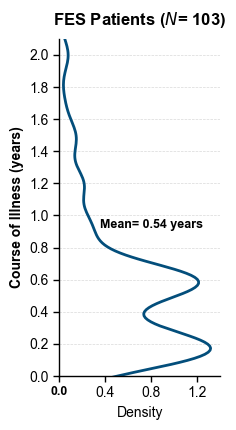


Descriptive Statistics for FES Patients (N=103):
Mean ± SD: 0.54 ± 0.43
Median: 0.50
Range: 0.10 - 2.00


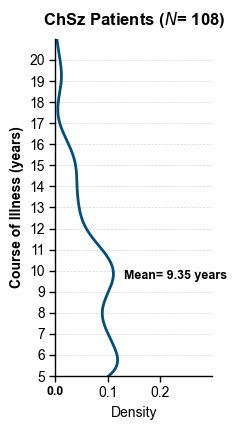


Descriptive Statistics for ChSz Patients (N=108):
Mean ± SD: 9.35 ± 3.54
Median: 9.00
Range: 5.00 - 20.00


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# 读取数据
df = pd.read_excel('table/data_cleaned.xlsx')

# 计算样本量并生成组标签
group_labels = {
    1: f"FES Patients (N={len(df[df['Group'] == 1])})",
    2: f"ChSz Patients (N={len(df[df['Group'] == 2])})"
}

# Nature风格设置
rcParams['font.family'] = 'Arial'

# 自定义样式设置
style_settings = {
    'density_linewidth': 2,             # 密度线宽
    'density_color': '#034e7b',         # 密度线颜色
    'density_alpha': 0.9,               # 密度线透明度
    
    'mean_text_offset_y': 0.4,          # 均值标注垂直偏移量
    'mean_text_size': 9,               # 均值标注字体大小
    'label_size': 10,                   # 轴标签字体大小
    'tick_size': 9,                     # 刻度标签字体大小
    
    'spine_width': 1.0,                 # 边框线宽
    'tick_length': 4,                   # 刻度线长度
    'tick_width': 1.0                   # 刻度线宽度
}

# Y轴和X轴范围设置
y_axis_settings = {
    1: {'ylim': (0, 2.1), 'yticks': np.arange(0, 2.1, 0.2)},
    2: {'ylim': (5, 21), 'yticks': range(5, 21, 1)}
}

x_axis_settings = {
    1: {'xlim': (0, 1.4), 'xticks': np.arange(0, 1.4, 0.4)},
    2: {'xlim': (0, 0.3), 'xticks': np.arange(0, 0.3, 0.1)}
}

# 分组绘制
for group, label in group_labels.items():
    # 筛选当前组数据
    group_data = df[df['Group'] == group]['Course of illness'].values
    
    # 创建图形
    fig, ax = plt.subplots(figsize=(2.4, 4.4))
    
    # 绘制密度曲线
    sns.kdeplot(
        y=group_data,  # 将数据分配给 y 参数
        ax=ax,
        color=style_settings['density_color'],
        linewidth=style_settings['density_linewidth'],
        alpha=style_settings['density_alpha'],
        bw_adjust=0.6  # 调整带宽，控制平滑程度
    )
    
    # 添加均值标注
    mean = np.mean(group_data)
    mean_text_x = 0.8 if group == 1 else 0.23  # 根据组别动态设置 X 坐标位置
    ax.text(mean_text_x, 
            mean + style_settings['mean_text_offset_y'],
            f'Mean= {mean:.2f} years',
            ha='center',
            va='center',
            fontsize=style_settings['mean_text_size'],
            fontname='Arial',
            fontweight='bold')
    
    # 设置标题
    title = "FES Patients ($N$= 103)" if group == 1 else "ChSz Patients ($N$= 108)"
    ax.set_title(title, fontsize=12, fontname='Arial', fontweight='bold', pad=10)
    
    # 设置标签和刻度
    ax.set_ylabel('Course of Illness (years)',
                 fontsize=style_settings['label_size'],
                 fontname='Arial',
                 fontweight='bold')
    ax.set_xticks([1])
    ax.set_xticklabels([label],
                       fontsize=style_settings['tick_size'],
                       fontname='Arial',
                       fontweight='bold')
    
    # 设置Y轴范围和刻度
    ax.set_ylim(y_axis_settings[group]['ylim'])
    ax.set_yticks(y_axis_settings[group]['yticks'])
    
    # 设置X轴范围和刻度
    ax.set_xlim(x_axis_settings[group]['xlim'])
    ax.set_xticks(x_axis_settings[group]['xticks'])
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))  # 格式化刻度为小数点1位

    # 设置边框样式
    for spine in ax.spines.values():
        spine.set_linewidth(style_settings['spine_width'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # 设置刻度样式
    ax.tick_params(width=style_settings['tick_width'],
                  length=style_settings['tick_length'])
 
    ax.grid(True, axis='y', color='gray', alpha=0.3, linestyle='--', linewidth=0.5)
    # 调整布局
    plt.tight_layout()
    
    # 保存图像
    plt.savefig(f"./image/course_of_illness_density_plot_group_{group}.jpg",
                dpi=1200,
                bbox_inches='tight')
    plt.show()
    
    # 打印描述性统计
    print(f"\nDescriptive Statistics for {label}:")
    print("=" * 50)
    stats = df[df['Group'] == group]['Course of illness'].describe()
    print(f"Mean ± SD: {stats['mean']:.2f} ± {stats['std']:.2f}")
    print(f"Median: {stats['50%']:.2f}")
    print(f"Range: {stats['min']:.2f} - {stats['max']:.2f}")

### 3.2

FES Patients (N=103): Mean = 11.41, Std = 5.03
ChSz Patients (N=108): Mean = 15.95, Std = 5.88


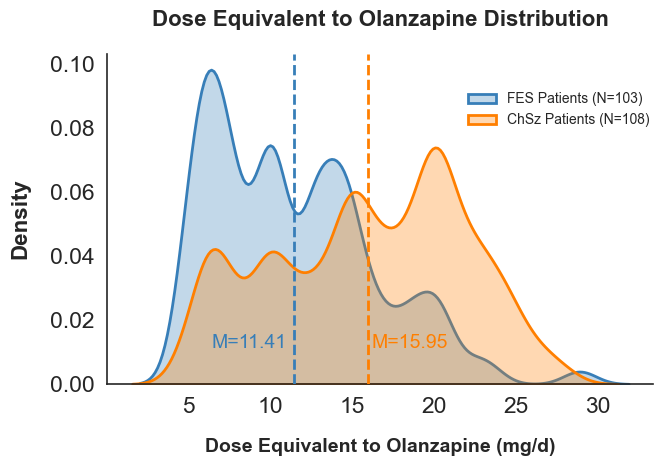

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_excel('table/data_cleaned.xlsx')

# 计算样本量并生成组标签
group_labels = {
    1: f"FES Patients (N={len(df[df['Group'] == 1])})",
    2: f"ChSz Patients (N={len(df[df['Group'] == 2])})"
}

# 提取分组数据
group1_data = df[df['Group'] == 1]['Dose Equivalent to Olanzapine (mg/d)']
group2_data = df[df['Group'] == 2]['Dose Equivalent to Olanzapine (mg/d)']

# 计算均值和标准差
mean_group1 = group1_data.mean()
std_group1 = group1_data.std()
mean_group2 = group2_data.mean()
std_group2 = group2_data.std()

# 打印均值和标准差
print(f"{group_labels[1]}: Mean = {mean_group1:.2f}, Std = {std_group1:.2f}")
print(f"{group_labels[2]}: Mean = {mean_group2:.2f}, Std = {std_group2:.2f}")

# 设置图形风格（接近 Nature 样式）
sns.set_theme(style="white", font_scale=1.5, rc={"axes.linewidth": 1.2, "grid.linewidth": 0.8})
plt.figure(figsize=(7, 5))

# 调整配色（使用易区分的高对比配色方案）
colors = ['#377eb8', '#ff7f00']

# 绘制分布对比图，将填充区域图层放在最底层
sns.kdeplot(group1_data, fill=True, label=group_labels[1], bw_adjust=0.5, alpha=0.3, color=colors[0], linewidth=2, zorder=1)
sns.kdeplot(group2_data, fill=True, label=group_labels[2], bw_adjust=0.5, alpha=0.3, color=colors[1], linewidth=2, zorder=1)

# 标注均值位置，将虚线放在最前面
plt.axvline(mean_group1, color=colors[0], linestyle='--', linewidth=2, zorder=3)  # 不添加 label
plt.axvline(mean_group2, color=colors[1], linestyle='--', linewidth=2, zorder=3)  # 不添加 label

# 添加均值标注文本
plt.text(mean_group1 - 5, 0.01, f"M={mean_group1:.2f}", fontsize=14, ha='left', va='bottom', color=colors[0])
plt.text(mean_group2 + 0.2, 0.01, f"M={mean_group2:.2f}", fontsize=14, ha='left', va='bottom', color=colors[1])

# 图形标题和轴标签
plt.title('Dose Equivalent to Olanzapine Distribution', fontsize=16, weight='bold', pad=20)
plt.xlabel('Dose Equivalent to Olanzapine (mg/d)', fontsize=14, weight='bold', labelpad=15)
plt.ylabel('Density', fontsize=16, weight='bold', labelpad=14)

# 图例优化（外置图例，只显示组别标签）
plt.legend(title='', fontsize=10, title_fontsize=14, loc='upper left', bbox_to_anchor=(0.65, 0.9), borderaxespad=0, ncol=1, frameon=False)

# 去掉多余边框，增加图形边距
sns.despine()
plt.tight_layout()

# 保存高分辨率图片
plt.savefig("./image/dose_equivalent_distribution_high_quality.jpg", dpi=1200, bbox_inches='tight')

# 显示图形
plt.show()

### 3.3

FES Patients (N=103): Mean = 29.65, Std = 9.65
ChSz Patients (N=108): Mean = 22.59, Std = 8.24
t-statistic = 5.7213, p-value = 0.0000
结果显示，两组之间存在显著差异


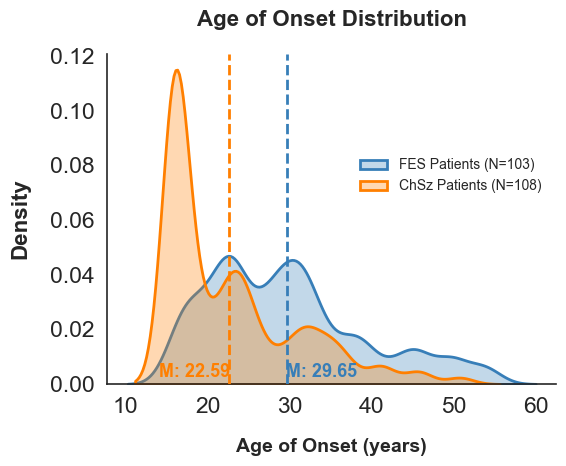

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

df = pd.read_excel('table/data_cleaned.xlsx')

# 计算样本量并生成组标签
group_labels = {
    1: f"FES Patients (N={len(df[df['Group'] == 1])})",
    2: f"ChSz Patients (N={len(df[df['Group'] == 2])})"
}

# 提取两组被试发病年龄数据（Age of onset）
group1_data = df[df['Group'] == 1]['Age of onset']
group2_data = df[df['Group'] == 2]['Age of onset']

# 计算均值和标准差
mean_group1 = group1_data.mean()
std_group1 = group1_data.std()
mean_group2 = group2_data.mean()
std_group2 = group2_data.std()

# 打印均值和标准差
print(f"{group_labels[1]}: Mean = {mean_group1:.2f}, Std = {std_group1:.2f}")
print(f"{group_labels[2]}: Mean = {mean_group2:.2f}, Std = {std_group2:.2f}")

# 进行独立样本t检验，检验两组发病年龄是否存在显著差异
t_stat, p_value = ttest_ind(group1_data, group2_data, nan_policy='omit')
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("结果显示，两组之间存在显著差异")
else:
    print("结果显示，两组之间不存在显著差异")

# 设置图形风格（接近 Nature 样式）
sns.set_theme(style="white", font_scale=1.5, rc={"axes.linewidth": 1.2, "grid.linewidth": 0.8})
plt.figure(figsize=(6, 5))

# 调整配色（使用易区分的高对比配色方案）
colors = ['#377eb8', '#ff7f00']

# 绘制分布对比图，将填充区域图层放在最底层
sns.kdeplot(group1_data, fill=True, label=group_labels[1], bw_adjust=0.5, alpha=0.3, color=colors[0], linewidth=2, zorder=1)
sns.kdeplot(group2_data, fill=True, label=group_labels[2], bw_adjust=0.5, alpha=0.3, color=colors[1], linewidth=2, zorder=1)

# 标注均值位置，将虚线放在最前面
plt.axvline(mean_group1, color=colors[0], linestyle='--', linewidth=2, zorder=3)  # 不添加 label
plt.axvline(mean_group2, color=colors[1], linestyle='--', linewidth=2, zorder=3)  # 不添加 label

# 添加均值标注文本
plt.text(mean_group1 + 8.5, plt.ylim()[1]*0.01, f"M: {mean_group1:.2f}", fontsize=13, ha='right', va='bottom', color=colors[0],fontweight='bold')
plt.text(mean_group2 - 8.5, plt.ylim()[1]*0.01, f"M: {mean_group2:.2f}", fontsize=13, ha='left', va='bottom', color=colors[1],fontweight='bold')

# 图形标题和轴标签
plt.title('Age of Onset Distribution', fontsize=16, weight='bold', pad=20)
plt.xlabel('Age of Onset (years)', fontsize=14, weight='bold', labelpad=15)
plt.ylabel('Density', fontsize=16, weight='bold', labelpad=14)

# 图例优化（外置图例，只显示组别标签）
plt.legend(title='', fontsize=10, title_fontsize=14, loc='upper left', bbox_to_anchor=(0.55, 0.7), borderaxespad=0, ncol=1, frameon=False)

# 去掉多余边框，增加图形边距
sns.despine()
plt.tight_layout()

# 保存高分辨率图片
plt.savefig("./image/age_onset_distribution_high_quality.jpg", dpi=1200, bbox_inches='tight')

# 显示图形
plt.show()

## 4.

### 4.1 

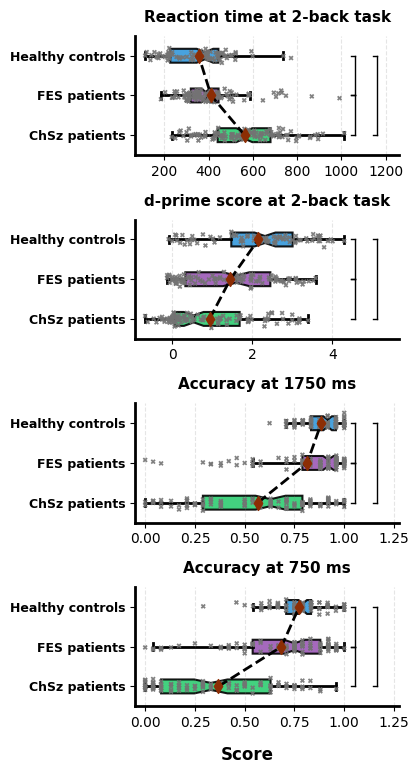

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy import stats

def get_significance_label(p):
    """根据p值返回显著性标记"""
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

def create_separate_horizontal_boxplots(data, metrics, titles,
                                        sig_adj_offset_factor=0.05,
                                        sig_adj_ext_factor=0.1,
                                        sig_nonadj_offset_factor=0.15,
                                        sig_nonadj_ext_factor=0.1,
                                        tick_length_factor=0.02,
                                        text_offset_factor=0.01):
    # 创建2x2子图
    fig, axes = plt.subplots(4,1, figsize=(4.2, 7.5), sharey=True)
    axes = axes.ravel()  # 将子图数组展平以便迭代

    # 定义各组颜色：
    # Group2: ChSz patients, Group1: FES patients, Group3: Healthy controls
    colors = ['#2ecc71', '#9b59b6', '#3498db']

    # 组标签及其对应位置（顺序：ChSz patients, FES patients, Healthy controls）
    groups = ['ChSz patients', 'FES patients', 'Healthy controls']
    num_groups = len(groups)
    positions = np.arange(1, num_groups + 1)  # y轴位置

    # 自定义箱线图样式
    boxplot_style = {
        'whiskerprops': {'linewidth': 2, 'color': 'black'},
        'medianprops': {'linewidth': 1, 'color': 'black'},
        'capprops': {'color': 'black', 'linewidth': 2},
        'notch': True,
        'patch_artist': True,
        'showfliers': False,
        'vert': False,  # 水平箱线图
        'zorder': 1
    }

    def plot_measure(ax, metric, title):
        # 按指定顺序准备数据：
        # 顺序：Group2 (ChSz patients), Group1 (FES patients), Group3 (Healthy controls)
        boxplot_data = [
            data[data['Group'] == 2][metric].dropna(),
            data[data['Group'] == 1][metric].dropna(),
            data[data['Group'] == 3][metric].dropna()
        ]

        # 计算均值以绘制连接线
        means = [np.mean(group_data) for group_data in boxplot_data]

        # 绘制每组箱线图，并分别上色
        for i, group_data in enumerate(boxplot_data):
            ax.boxplot([group_data],
                       positions=[positions[i]],
                       widths=0.35,
                       boxprops=dict(facecolor=colors[i],
                                     edgecolor='black',
                                     linewidth=1.5,
                                     alpha=0.9),
                       **boxplot_style)

        # 绘制散点以显示单个数据点（添加随机扰动避免重叠）
        for j, group_data in enumerate(boxplot_data):
            y = np.random.normal(positions[j], 0.08, size=len(group_data))
            ax.scatter(group_data, y,
                       color='#737373',
                       alpha=0.9,
                       s=13,
                       edgecolors='none',
                       marker='X',
                       zorder=2)

        # 绘制均值的连接线和均值标记
        ax.plot(means, positions, color='black', linestyle='--', linewidth=2, zorder=3)
        ax.scatter(means, positions, color='#8c2d04', marker='d', s=50, zorder=4)

        # 确定数据区域右端位置，为放置显著性标注
        all_vals = np.concatenate([group.values for group in boxplot_data])
        global_max = np.max(all_vals)
        x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
        
        # 相邻组标注线位置
        annotation_x = global_max + sig_adj_offset_factor * x_range
        ax.set_xlim(ax.get_xlim()[0], annotation_x + sig_adj_ext_factor * x_range)
        tick_length = tick_length_factor * x_range  # 横线刻度长度

        # -----------------------------
        # 标注相邻组比较：Group2 vs FES patients 和 FES patients vs Healthy controls（仅保留线条）
        # -----------------------------
        for idx in range(len(positions) - 1):
            group1 = boxplot_data[idx]
            group2 = boxplot_data[idx + 1]
            t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
            # 这里计算得到的sig_label暂不显示
            y1 = positions[idx]
            y2 = positions[idx + 1]
            # 绘制竖直连接线（线宽改为1.0）
            ax.plot([annotation_x, annotation_x], [y1, y2],
                    color='black', lw=1.0, zorder=5)
            # 绘制两端的横线（线宽改为1.0）
            ax.plot([annotation_x, annotation_x - tick_length], [y1, y1],
                    color='black', lw=1.0, zorder=5)
            ax.plot([annotation_x, annotation_x - tick_length], [y2, y2],
                    color='black', lw=1.0, zorder=5)
            # 若后续需要添加文本，可在此处添加 ax.text(...)

        # -----------------------------
        # 标注非相邻组比较：Group2 vs Healthy controls（仅保留线条）
        # -----------------------------
        group1 = boxplot_data[0]
        group2 = boxplot_data[2]
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        # 这里计算得到的sig_label暂不显示
        y1 = positions[0]
        y2 = positions[2]
        # annotation_x2用于非相邻组标注，放在更右侧
        annotation_x2 = global_max + sig_nonadj_offset_factor * x_range
        ax.set_xlim(ax.get_xlim()[0], annotation_x2 + sig_nonadj_ext_factor * x_range)
        ax.plot([annotation_x2, annotation_x2], [y1, y2],
                color='black', lw=1.0, zorder=5)
        ax.plot([annotation_x2, annotation_x2 - tick_length], [y1, y1],
                color='black', lw=1.0, zorder=5)
        ax.plot([annotation_x2, annotation_x2 - tick_length], [y2, y2],
                color='black', lw=1.0, zorder=5)
        # 此处同样预留添加文本的位置

        # 自定义坐标轴及图形样式
        ax.set_title(title, fontsize=11, pad=10, fontweight='bold')
        ax.xaxis.grid(True, linestyle='--', alpha=0.2, color='gray')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.set_yticks(positions)
        ax.set_yticklabels(groups, fontsize=9, fontweight='bold')

    # 针对每个指标绘图
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        plot_measure(axes[i], metric, title)

    # 添加共享x轴标签
    fig.text(0.6, -0.02, 'Score', ha='center', fontsize=12, fontweight='bold')
    plt.tight_layout()
    return fig

# 从Excel中读取数据
data = pd.read_excel('table/data_cleaned.xlsx')

# 定义指标及对应的标题
metrics = [
    'Reaction time at 2-back task', 
    'd-prime score at 2-back task', 
    'Accuracy at 1750 ms', 
    'Accuracy at 750 ms'
]
titles = [
    'Reaction time at 2-back task', 
    'd-prime score at 2-back task', 
    'Accuracy at 1750 ms', 
    'Accuracy at 750 ms'
]

# 创建合并图并保存图片
combined_fig = create_separate_horizontal_boxplots(data, metrics, titles,
                                                   sig_adj_offset_factor=0.05,
                                                   sig_adj_ext_factor=0.1,
                                                   sig_nonadj_offset_factor=0.15,
                                                   sig_nonadj_ext_factor=0.1,
                                                   tick_length_factor=0.02,
                                                   text_offset_factor=0.01)
combined_fig.savefig('image/horizontal_boxplots.jpg', dpi=1200, bbox_inches='tight', pad_inches=0.3)
plt.show()

### 4.3 

In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 读取数据
data = pd.read_excel('table/data_cleaned.xlsx')

# 清理列名
data.columns = [col.strip().replace(' ', '_').replace('-', '_').replace('.', '') for col in data.columns]
# 打印列名
print(data.columns)

# 确保数据列名与清理后的列名一致
expected_columns = [
    'ID', 'EprimeID1750', 'EprimeID2back', 'Age_of_onset', 'Gender', 'Education_level', 'Course_of_illness', 
    'Group', 'Accuracy_at_1750_ms', 'Accuracy_at_750_ms', 'd_prime_score_at_2_back_task', 
    'Reaction_time_at_2_back_task', 'PANSS_P', 'PANSS_N', 'PANSS_GP', 'PANSS_T'
]
missing_columns = [col for col in expected_columns if col not in data.columns]
if missing_columns:
    raise ValueError(f"The following expected columns are missing in the data: {missing_columns}")

# 排除Group=3的数据
data = data[data['Group'] != 3]

# 动态更新EF变量列表
ef_measures = ['Accuracy_at_1750_ms', 'Accuracy_at_750_ms', 'd_prime_score_at_2_back_task', 'Reaction_time_at_2_back_task']

# 选择社会人口学变量
socio_demo_vars_cont = ['Age_of_onset']
socio_demo_vars_cat = ['Gender', 'Education_level']

# 对执行功能变量进行标准化处理
scaler = StandardScaler()
data[ef_measures] = scaler.fit_transform(data[ef_measures])

# 将分类变量转换为虚拟变量
data_encoded = pd.get_dummies(data[['Group'] + ef_measures + socio_demo_vars_cont + socio_demo_vars_cat], 
                              columns=socio_demo_vars_cat, drop_first=True)

# 单因素ANCOVA和FDR校正
print("\nOne-way ANCOVA with FDR Correction:")
p_values = []
eta_squared_values = []  # 存储eta-squared值的列表

for ef_measure in ef_measures:
    # 定义公式
    formula = f'{ef_measure} ~ Group + ' + ' + '.join(socio_demo_vars_cont + 
                                                      [col for col in data_encoded.columns if col.startswith(tuple(socio_demo_vars_cat))])
    # 构建模型
    ancova_model = sm.formula.ols(formula, data=data_encoded).fit()
    print(f"\n{ef_measure}:\n")
    print(ancova_model.summary())
    
    # 提取Group主效应的p值
    p_values.append(ancova_model.pvalues['Group'])
    
    # 计算Eta-squared
    anova_results = anova_lm(ancova_model)
    ss_group = anova_results['sum_sq']['Group']
    ss_total = anova_results['sum_sq'].sum()
    eta_squared = ss_group / ss_total
    eta_squared_values.append(eta_squared)
    print(f"Eta-squared (η²): {eta_squared:.2f}")

# 应用FDR校正
rejected, corrected_p_values = multipletests(p_values, method='fdr_bh')[:2]
print("\nFDR-corrected p-values:")
for ef_measure, p, corr_p in zip(ef_measures, p_values, corrected_p_values):
    print(f"{ef_measure}: original p = {p:.4f}, FDR-corrected p = {corr_p:.4f}")

Index(['ID', 'EprimeID1750', 'EprimeID2back', 'Reaction_time_at_2_back_task',
       'Dose_Equivalent_to_Olanzapine_(mg/d)', 'Age', 'Gender',
       'Education_level', 'Accuracy_at_1750_ms', 'Accuracy_at_750_ms',
       'Course_of_illness', 'Group', 'PANSS_P', 'PANSS_N', 'PANSS_GP',
       'PANSS_T', 'Age_of_onset', 'd_prime_score_at_2_back_task', 'Hit_Rate',
       'False_Alarm_Rate', 'Hits', 'False_Alarms'],
      dtype='object')

One-way ANCOVA with FDR Correction:

Accuracy_at_1750_ms:

                             OLS Regression Results                            
Dep. Variable:     Accuracy_at_1750_ms   R-squared:                       0.211
Model:                             OLS   Adj. R-squared:                  0.180
Method:                  Least Squares   F-statistic:                     6.744
Date:                 Mon, 31 Mar 2025   Prob (F-statistic):           7.89e-08
Time:                         12:25:22   Log-Likelihood:                -274.42
No. Observations:       

### 4.4

In [3]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
import warnings
from tabulate import tabulate

warnings.filterwarnings('ignore')

# 读取数据
data = pd.read_excel('table/data_cleaned.xlsx')

# 清理列名
data.columns = [col.strip().replace(' ', '_').replace('-', '_').replace('.', '') for col in data.columns]
print("Data columns:", data.columns)

# 确保所有预期的列都存在
expected_columns = [
    'ID', 'EprimeID1750', 'EprimeID2back', 'Age', 'Gender', 'Education_level', 'Course_of_illness', 
    'Group', 'Accuracy_at_1750_ms', 'Accuracy_at_750_ms', 'd_prime_score_at_2_back_task', 
    'Reaction_time_at_2_back_task', 'PANSS_P', 'PANSS_N', 'PANSS_GP', 'PANSS_T', 'Age_of_onset'
]
missing_columns = [col for col in expected_columns if col not in data.columns]
if missing_columns:
    raise ValueError(f"The following expected columns are missing in the data: {missing_columns}")

# 对 Group 列进行映射：FES patients、ChSz patients 和 Healthy controls
group_map = {1: 'FES patients', 2: 'ChSz patients', 3: 'Healthy controls'}
data['Group'] = data['Group'].map(group_map)

# 定义执行功能指标（EF）和社会人口学变量
ef_measures = ['Accuracy_at_1750_ms', 'Accuracy_at_750_ms', 'd_prime_score_at_2_back_task', 'Reaction_time_at_2_back_task']
socio_demo_vars_cont = ['Age', ]
socio_demo_vars_cat = ['Gender', 'Education_level']

# ---------------------- 描述性统计：原始均值 ± 标准差（三线表） ----------------------
# 注意：这里使用未标准化的原始数据
data_orig = data.copy()
desc_stats = data_orig.groupby('Group')[ef_measures].agg(['mean', 'std'])
# 构造新的DataFrame，将均值和标准差合并为 "mean ± std" 字符串
desc_table = pd.DataFrame(index=desc_stats.index)
for measure in ef_measures:
    desc_table[measure] = desc_stats[(measure, 'mean')].map("{:.2f}".format) + " ± " + desc_stats[(measure, 'std')].map("{:.2f}".format)
    
print("\nDescriptive statistics (Mean ± SD) for EF measures by Group:")
print(tabulate(desc_table, headers='keys', tablefmt='psql'))

# ---------------------- 数据预处理 ----------------------
# 对执行功能变量进行标准化处理
scaler = StandardScaler()
data[ef_measures] = scaler.fit_transform(data[ef_measures])

# 将分类变量转换为虚拟变量（Group 保留原始类别）
data_encoded = pd.get_dummies(data[['Group'] + ef_measures + socio_demo_vars_cont + socio_demo_vars_cat], 
                              columns=socio_demo_vars_cat, drop_first=True)

print("\nOne-way ANCOVA with FDR Correction:")

p_values = []
eta_squared_values = []  # 存储η²值

# 针对每个 EF 指标进行 ANCOVA 分析
for ef_measure in ef_measures:
    # 构建公式：EF指标 ~ Group + 连续型协变量 + 分类虚拟变量
    # 注意：分类变量 "Group" 会被自动转换为虚拟变量，其整体效应可通过 ANOVA 表获取
    formula = f'{ef_measure} ~ Group + ' + ' + '.join(socio_demo_vars_cont + 
                                                      [col for col in data_encoded.columns if col.startswith(tuple(socio_demo_vars_cat))])
    ancova_model = sm.formula.ols(formula, data=data_encoded).fit()
    print(f"\n{ef_measure}:\n")
    print(ancova_model.summary())
    
    # 通过 ANOVA 表提取 Group 主效应的 p 值
    anova_results = anova_lm(ancova_model)
    p_val = anova_results.loc['Group', 'PR(>F)']
    p_values.append(p_val)
    
    # 计算η²：Group效应平方和 / 总平方和
    ss_group = anova_results.loc['Group', 'sum_sq']
    ss_total = anova_results['sum_sq'].sum()
    eta_squared = ss_group / ss_total
    eta_squared_values.append(eta_squared)
    print(f"Eta-squared (η²): {eta_squared:.2f}")

# 对所有 Group 主效应的 p 值进行 FDR 校正
rejected, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')
print("\nFDR-corrected p-values:")
for ef_measure, p, corr_p in zip(ef_measures, p_values, corrected_p_values):
    print(f"{ef_measure}: original p = {p:.4f}, FDR-corrected p = {corr_p:.4f}")

# 对于 FDR 校正后显著的 EF 指标进行事后比较（使用 Tukey HSD，不调整协变量，仅作为补充分析）
print("\nPost-hoc comparisons (Tukey HSD) for significant effects:")
for ef_measure, corr_p in zip(ef_measures, corrected_p_values):
    if corr_p < 0.05:
        print(f"\nPost-hoc comparisons for {ef_measure}:")
        tukey = pairwise_tukeyhsd(endog=data[ef_measure], groups=data['Group'], alpha=0.05)
        print(tukey.summary())

Data columns: Index(['ID', 'EprimeID1750', 'EprimeID2back', 'Reaction_time_at_2_back_task',
       'Dose_Equivalent_to_Olanzapine_(mg/d)', 'Age', 'Gender',
       'Education_level', 'Accuracy_at_1750_ms', 'Accuracy_at_750_ms',
       'Course_of_illness', 'Group', 'PANSS_P', 'PANSS_N', 'PANSS_GP',
       'PANSS_T', 'Age_of_onset', 'd_prime_score_at_2_back_task', 'Hit_Rate',
       'False_Alarm_Rate', 'Hits', 'False_Alarms'],
      dtype='object')

Descriptive statistics (Mean ± SD) for EF measures by Group:
+------------------+-----------------------+----------------------+--------------------------------+--------------------------------+
| Group            | Accuracy_at_1750_ms   | Accuracy_at_750_ms   | d_prime_score_at_2_back_task   | Reaction_time_at_2_back_task   |
|------------------+-----------------------+----------------------+--------------------------------+--------------------------------|
| ChSz patients    | 0.57 ± 0.29           | 0.37 ± 0.28          | 0.93 ± 1.06       

### 4.5

In [4]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
import warnings
from tabulate import tabulate

warnings.filterwarnings('ignore')

# 读取数据
data = pd.read_excel('table/data_cleaned.xlsx')

# 清理列名
data.columns = [col.strip().replace(' ', '_').replace('-', '_').replace('.', '') for col in data.columns]
print("Data columns:", data.columns)

# 确保所有预期的列都存在
expected_columns = [
    'ID', 'EprimeID1750', 'EprimeID2back', 'Age', 'Gender', 'Education_level', 'Course_of_illness', 
    'Group', 'd_prime_score_at_2_back_task', 'Hit_Rate', 'False_Alarm_Rate', 'Hits', 'False_Alarms'
]
missing_columns = [col for col in expected_columns if col not in data.columns]
if missing_columns:
    raise ValueError(f"The following expected columns are missing in the data: {missing_columns}")

# 对 Group 列进行映射：FES patients、ChSz patients 和 Healthy controls
group_map = {1: 'FES patients', 2: 'ChSz patients', 3: 'Healthy controls'}
data['Group'] = data['Group'].map(group_map)

# 定义执行功能指标（EF）和社会人口学变量
# 更新ef_measures为：d-prime score at 2-back task、Hit Rate、False Alarm Rate、Hits、False Alarms
ef_measures = ['d_prime_score_at_2_back_task', 'Hit_Rate', 'False_Alarm_Rate', 'Hits', 'False_Alarms']
socio_demo_vars_cont = ['Age']
socio_demo_vars_cat = ['Gender', 'Education_level']

# ---------------------- 描述性统计：原始均值 ± 标准差（三线表） ----------------------
# 注意：这里使用未标准化的原始数据
data_orig = data.copy()
desc_stats = data_orig.groupby('Group')[ef_measures].agg(['mean', 'std'])
# 构造新的DataFrame，将均值和标准差合并为 "mean ± std" 字符串
desc_table = pd.DataFrame(index=desc_stats.index)
for measure in ef_measures:
    desc_table[measure] = desc_stats[(measure, 'mean')].map("{:.2f}".format) + " ± " + desc_stats[(measure, 'std')].map("{:.2f}".format)
    
print("\nDescriptive statistics (Mean ± SD) for EF measures by Group:")
print(tabulate(desc_table, headers='keys', tablefmt='psql'))

# ---------------------- 数据预处理 ----------------------
# 对执行功能变量进行标准化处理
scaler = StandardScaler()
data[ef_measures] = scaler.fit_transform(data[ef_measures])

# 将分类变量转换为虚拟变量（Group 保留原始类别）
data_encoded = pd.get_dummies(data[['Group'] + ef_measures + socio_demo_vars_cont + socio_demo_vars_cat], 
                              columns=socio_demo_vars_cat, drop_first=True)

print("\nOne-way ANCOVA with FDR Correction:")

p_values = []
eta_squared_values = []  # 存储η²值

# 针对每个 EF 指标进行 ANCOVA 分析
for ef_measure in ef_measures:
    # 构建公式：EF指标 ~ Group + 连续型协变量 + 分类虚拟变量
    # 注意：分类变量 "Group" 会被自动转换为虚拟变量，其整体效应可通过 ANOVA 表获取
    formula = f'{ef_measure} ~ Group + ' + ' + '.join(socio_demo_vars_cont +
                                                      [col for col in data_encoded.columns if col.startswith(tuple(socio_demo_vars_cat))])
    ancova_model = sm.formula.ols(formula, data=data_encoded).fit()
    print(f"\n{ef_measure}:\n")
    print(ancova_model.summary())
    
    # 通过 ANOVA 表提取 Group 主效应的 p 值
    anova_results = anova_lm(ancova_model)
    p_val = anova_results.loc['Group', 'PR(>F)']
    p_values.append(p_val)
    
    # 计算η²：Group效应平方和 / 总平方和
    ss_group = anova_results.loc['Group', 'sum_sq']
    ss_total = anova_results['sum_sq'].sum()
    eta_squared = ss_group / ss_total
    eta_squared_values.append(eta_squared)
    print(f"Eta-squared (η²): {eta_squared:.2f}")

# 对所有 Group 主效应的 p 值进行 FDR 校正
rejected, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')
print("\nFDR-corrected p-values:")
for ef_measure, p, corr_p in zip(ef_measures, p_values, corrected_p_values):
    print(f"{ef_measure}: original p = {p:.4f}, FDR-corrected p = {corr_p:.4f}")

# 对于 FDR 校正后显著的 EF 指标进行事后比较（使用 Tukey HSD，不调整协变量，仅作为补充分析）
print("\nPost-hoc comparisons (Tukey HSD) for significant effects:")
for ef_measure, corr_p in zip(ef_measures, corrected_p_values):
    if corr_p < 0.05:
        print(f"\nPost-hoc comparisons for {ef_measure}:")
        tukey = pairwise_tukeyhsd(endog=data[ef_measure], groups=data['Group'], alpha=0.05)
        print(tukey.summary())

Data columns: Index(['ID', 'EprimeID1750', 'EprimeID2back', 'Reaction_time_at_2_back_task',
       'Dose_Equivalent_to_Olanzapine_(mg/d)', 'Age', 'Gender',
       'Education_level', 'Accuracy_at_1750_ms', 'Accuracy_at_750_ms',
       'Course_of_illness', 'Group', 'PANSS_P', 'PANSS_N', 'PANSS_GP',
       'PANSS_T', 'Age_of_onset', 'd_prime_score_at_2_back_task', 'Hit_Rate',
       'False_Alarm_Rate', 'Hits', 'False_Alarms'],
      dtype='object')

Descriptive statistics (Mean ± SD) for EF measures by Group:
+------------------+--------------------------------+-------------+--------------------+--------------+----------------+
| Group            | d_prime_score_at_2_back_task   | Hit_Rate    | False_Alarm_Rate   | Hits         | False_Alarms   |
|------------------+--------------------------------+-------------+--------------------+--------------+----------------|
| ChSz patients    | 0.93 ± 1.06                    | 0.61 ± 0.18 | 0.32 ± 0.20        | 23.38 ± 8.01 | 11.88 ± 7.93   |
| FE

## 5.

### 5.1

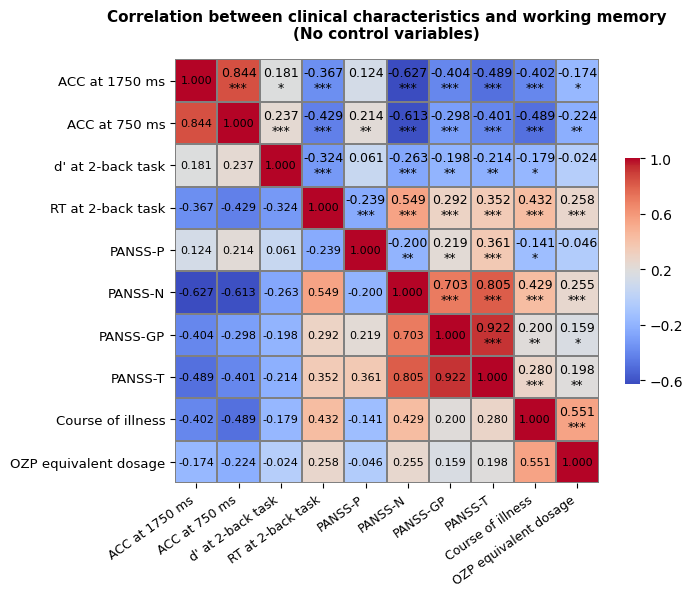

结果已保存到 'correlation_results.xlsx'

显著性标记说明：
*   p < 0.05
**  p < 0.01
*** p < 0.001


In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.multitest import multipletests, fdrcorrection
import seaborn as sns
import matplotlib.pyplot as plt

# 读取Excel文件
df = pd.read_excel('table/data_cleaned.xlsx')

# 排除 Group = 3 的样本
df = df[df['Group'] != 3]

# 要分析的主要变量（已增加 "d' at 2-back task"）
columns_to_analyze = [
    'Accuracy at 1750 ms',
    'Accuracy at 750 ms', 
    "d-prime score at 2-back task",
    'Reaction time at 2-back task', 
    'PANSS-P',
    'PANSS-N', 
    'PANSS-GP',
    'PANSS-T',
    'Course of illness', 
    'Dose Equivalent to Olanzapine (mg/d)',
]

# --------------------------------------------------
# 定义计算简单相关系数的函数（不控制无关变量）
# --------------------------------------------------
def partial_corr(x, y, df):
    r, p = stats.pearsonr(df[x], df[y])
    return r, p

# 构建相关系数矩阵和p值矩阵
n = len(columns_to_analyze)
partial_corr_matrix = np.zeros((n, n))
pvals_matrix = np.ones((n, n))

for i in range(n):
    for j in range(n):
        if i == j:
            partial_corr_matrix[i, j] = 1.0
            pvals_matrix[i, j] = 0.0
        elif i < j:
            r, p = partial_corr(columns_to_analyze[i], columns_to_analyze[j], df)
            partial_corr_matrix[i, j] = r
            partial_corr_matrix[j, i] = r
            pvals_matrix[i, j] = p
            pvals_matrix[j, i] = p

# 对上三角非对角线部分进行FDR校正
upper_tri_indices = np.triu_indices(n, k=1)
pvals = pvals_matrix[upper_tri_indices]
fdr_results = multipletests(pvals, alpha=0.05, method='fdr_bh')
fdr_rejected = fdr_results[0]
fdr_pvals = fdr_results[1]

# 绘制相关系数热力图
plt.figure(figsize=(7.5, 7))
sns.heatmap(
    partial_corr_matrix, 
    annot=False,  # 不自动标注
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.2,
    linecolor="gray", 
    cbar_kws={
        "shrink": 0.4,
        "aspect": 15, 
        "pad": 0.05,
        "ticks": np.arange(-1, 1.1, 0.4)  
    }
)

# 列名映射为更简洁的标签（新增变量的标签也已更新）
column_labels = {
    'Accuracy at 1750 ms': 'ACC at 1750 ms',
    'Accuracy at 750 ms': 'ACC at 750 ms',
    'Accuracy at 2-back task': 'ACC at 2-back task',
    "d-prime score at 2-back task": "d' at 2-back task",
    'Reaction time at 2-back task': 'RT at 2-back task',
    'PANSS-P': 'PANSS-P',
    'PANSS-N': 'PANSS-N',
    'PANSS-GP': 'PANSS-GP',
    'PANSS-T': 'PANSS-T',
    'Course of illness': 'Course of illness',
    'Dose Equivalent to Olanzapine (mg/d)': 'OZP equivalent dosage',
}

# 手动标注相关系数和FDR校正后的显著性星号（相关系数显示三位小数）
idx = 0  
for i in range(n):
    for j in range(n):
        coef = partial_corr_matrix[i, j]
        if i < j:  # 只标注上三角
            if fdr_rejected[idx]:
                if fdr_pvals[idx] < 0.001:
                    sig = '***'
                elif fdr_pvals[idx] < 0.01:
                    sig = '**'    
                else:
                    sig = '*'
            else:
                sig = ''
            plt.text(
                j + 0.5,
                i + 0.5,
                f"{coef:.3f}\n{sig}",
                ha="center",
                va="center",   
                color="black",
                fontsize=9
            )
            idx += 1
        else:
            plt.text(
                j + 0.5,
                i + 0.5,
                f"{coef:.3f}",
                ha="center",
                va="center",
                color="black",  
                fontsize=8
            )

plt.title("Correlation between clinical characteristics and working memory\n(No control variables)", fontsize=11, fontweight="bold", pad=15)
plt.xticks(
    np.arange(0.5, n, 1),
    labels=[column_labels[col] for col in columns_to_analyze],
    rotation=35, 
    fontsize=9,
    ha='right'
)    
plt.yticks(
    np.arange(0.5, n, 1),  
    labels=[column_labels[col] for col in columns_to_analyze],
    rotation=0, 
    fontsize=9.5
)

plt.tight_layout(pad=2)  
plt.savefig('./image/correlation_matrix_fdr.jpg', dpi=1200, bbox_inches='tight') 
plt.show()

# ------------------------- 保存Excel结果 -------------------------

# 对上三角的p值进行FDR校正（使用fdrcorrection函数）
rejected, p_adjusted = fdrcorrection(pvals, alpha=0.05, method='indep')
adjusted_p_matrix = np.zeros_like(pvals_matrix)
k = 0
for i in range(n):
    for j in range(i+1, n):
        adjusted_p_matrix[i, j] = p_adjusted[k]
        adjusted_p_matrix[j, i] = p_adjusted[k]  # 构造对称矩阵
        k += 1
np.fill_diagonal(adjusted_p_matrix, 1.0)  # 填充对角线

# 创建显著性标记矩阵（* for p < 0.05, ** for p < 0.01, *** for p < 0.001）
significance_matrix = np.full_like(adjusted_p_matrix, '', dtype=object)
for i in range(n):
    for j in range(n):
        if i != j:  # 跳过对角线
            adj_p = adjusted_p_matrix[i, j]
            if adj_p < 0.001:
                significance_matrix[i, j] = '***'
            elif adj_p < 0.01:
                significance_matrix[i, j] = '**'
            elif adj_p < 0.05:
                significance_matrix[i, j] = '*'

# 保存结果到Excel
with pd.ExcelWriter('./table/correlation_results.xlsx') as writer:
    # 保存相关系数矩阵
    pd.DataFrame(partial_corr_matrix, index=columns_to_analyze, columns=columns_to_analyze).round(3).to_excel(writer, sheet_name='Correlation Coefficients')
    
    # 保存原始p值矩阵（相关性计算得到的p值）
    pd.DataFrame(pvals_matrix, index=columns_to_analyze, columns=columns_to_analyze).round(4).to_excel(writer, sheet_name='Original P-values')
    
    # 保存FDR校正后的p值矩阵
    pd.DataFrame(adjusted_p_matrix, index=columns_to_analyze, columns=columns_to_analyze).round(4).to_excel(writer, sheet_name='FDR Adjusted P-values')
    
    # 保存显著性标记矩阵
    pd.DataFrame(significance_matrix, index=columns_to_analyze, columns=columns_to_analyze).to_excel(writer, sheet_name='Significance Markers')
    
    # 创建综合结果矩阵（相关系数+显著性标记）
    combined_matrix = np.full_like(partial_corr_matrix, '', dtype=object)
    for i in range(n):
        for j in range(n):
            r_val = partial_corr_matrix[i, j]
            sig_marker = significance_matrix[i, j]
            combined_matrix[i, j] = f"{r_val:.3f}{sig_marker}"
    
    pd.DataFrame(combined_matrix, index=columns_to_analyze, columns=columns_to_analyze).to_excel(writer, sheet_name='Combined Results')

print("结果已保存到 'correlation_results.xlsx'")
print("\n显著性标记说明：")
print("*   p < 0.05")
print("**  p < 0.01")
print("*** p < 0.001")

### 5.2

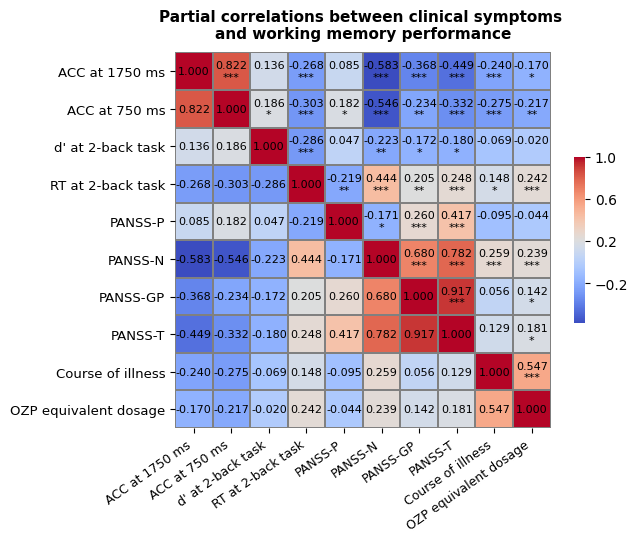

结果已保存到 'correlation_results-偏相关.xlsx'

显著性标记说明：
*   p < 0.05
**  p < 0.01
*** p < 0.001


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.multitest import multipletests, fdrcorrection
import seaborn as sns
import matplotlib.pyplot as plt

# 读取Excel文件
df = pd.read_excel('table/data_cleaned.xlsx')

# 排除 Group = 3 的样本
df = df[df['Group'] != 3]

# 要分析的主要变量
columns_to_analyze = [
    'Accuracy at 1750 ms',
    'Accuracy at 750 ms', 
    "d-prime score at 2-back task",
    'Reaction time at 2-back task', 
    'PANSS-P',
    'PANSS-N', 
    'PANSS-GP',
    'PANSS-T',
    'Course of illness', 
    'Dose Equivalent to Olanzapine (mg/d)',
]

# 控制变量
covariates = ['Age of onset', 'Gender', 'Education level', 'Age']

# 计算偏相关函数（不再区分OZP是否控制Age of onset）
def partial_corr(x, y, covariates, df):
    X = sm.add_constant(df[covariates])
    model_x = sm.OLS(df[x], X).fit()
    res_x = model_x.resid

    model_y = sm.OLS(df[y], X).fit()
    res_y = model_y.resid

    r, p = stats.pearsonr(res_x, res_y)
    return r, p

# 构建偏相关矩阵和p值矩阵
n = len(columns_to_analyze)
partial_corr_matrix = np.zeros((n, n))
pvals_matrix = np.ones((n, n))

for i in range(n):
    for j in range(n):
        if i == j:
            partial_corr_matrix[i, j] = 1.0
            pvals_matrix[i, j] = 0.0
        elif i < j:
            r, p = partial_corr(columns_to_analyze[i], columns_to_analyze[j], covariates, df)
            partial_corr_matrix[i, j] = r
            partial_corr_matrix[j, i] = r
            pvals_matrix[i, j] = p
            pvals_matrix[j, i] = p

# FDR校正
upper_tri_indices = np.triu_indices(n, k=1)
pvals = pvals_matrix[upper_tri_indices]
fdr_results = multipletests(pvals, alpha=0.05, method='fdr_bh')
fdr_rejected = fdr_results[0]
fdr_pvals = fdr_results[1]

# 热力图绘制
plt.figure(figsize=(6.9, 6.7))
sns.heatmap(
    partial_corr_matrix, 
    annot=False,
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.2,
    linecolor="gray", 
    cbar_kws={
        "shrink": 0.3,
        "aspect": 15, 
        "pad": 0.05,
        "ticks": np.arange(-1, 1.1, 0.4)
    }
)

# 简洁标签
column_labels = {
    'Accuracy at 1750 ms': 'ACC at 1750 ms',
    'Accuracy at 750 ms': 'ACC at 750 ms',
    'Accuracy at 2-back task': 'ACC at 2-back task',
    "d-prime score at 2-back task": "d' at 2-back task",
    'Reaction time at 2-back task': 'RT at 2-back task',
    'PANSS-P': 'PANSS-P',
    'PANSS-N': 'PANSS-N',
    'PANSS-GP': 'PANSS-GP',
    'PANSS-T': 'PANSS-T',
    'Course of illness': 'Course of illness',
    'Dose Equivalent to Olanzapine (mg/d)': 'OZP equivalent dosage',
}

# 标注显著性和相关系数
idx = 0  
for i in range(n):
    for j in range(n):
        coef = partial_corr_matrix[i, j]
        if i < j:
            if fdr_rejected[idx]:
                if fdr_pvals[idx] < 0.001:
                    sig = '***'
                elif fdr_pvals[idx] < 0.01:
                    sig = '**'
                else:
                    sig = '*'
            else:
                sig = ''
            plt.text(
                j + 0.5,
                i + 0.5,
                f"{coef:.3f}\n{sig}",
                ha="center",
                va="center",
                color="black",
                fontsize=8
            )
            idx += 1
        else:
            plt.text(
                j + 0.5,
                i + 0.5,
                f"{coef:.3f}",
                ha="center",
                va="center",
                color="black",
                fontsize=8
            )

plt.title("Partial correlations between clinical symptoms \nand working memory performance", fontsize=11, fontweight="bold", pad=10)
plt.xticks(
    np.arange(0.5, n, 1),
    labels=[column_labels[col] for col in columns_to_analyze],
    rotation=35,
    fontsize=9,
    ha='right'
)
plt.yticks(
    np.arange(0.5, n, 1),
    labels=[column_labels[col] for col in columns_to_analyze],
    rotation=0,
    fontsize=9.5
)

plt.tight_layout(pad=2)
plt.savefig('./image/partial_correlation_matrix_fdr.jpg', dpi=1200, bbox_inches='tight')
plt.show()

# 保存Excel结果
rejected, p_adjusted = fdrcorrection(pvals, alpha=0.05, method='indep')
adjusted_p_matrix = np.zeros_like(pvals_matrix)
k = 0
for i in range(n):
    for j in range(i+1, n):
        adjusted_p_matrix[i, j] = p_adjusted[k]
        adjusted_p_matrix[j, i] = p_adjusted[k]
        k += 1
np.fill_diagonal(adjusted_p_matrix, 1.0)

significance_matrix = np.full_like(adjusted_p_matrix, '', dtype=object)
for i in range(n):
    for j in range(n):
        if i != j:
            adj_p = adjusted_p_matrix[i, j]
            if adj_p < 0.001:
                significance_matrix[i, j] = '***'
            elif adj_p < 0.01:
                significance_matrix[i, j] = '**'
            elif adj_p < 0.05:
                significance_matrix[i, j] = '*'

with pd.ExcelWriter('./table/correlation_results-偏相关.xlsx') as writer:
    pd.DataFrame(partial_corr_matrix, index=columns_to_analyze, columns=columns_to_analyze).round(3).to_excel(writer, sheet_name='Partial Corr Coefficients')
    pd.DataFrame(pvals_matrix, index=columns_to_analyze, columns=columns_to_analyze).round(4).to_excel(writer, sheet_name='Original P-values')
    pd.DataFrame(adjusted_p_matrix, index=columns_to_analyze, columns=columns_to_analyze).round(4).to_excel(writer, sheet_name='FDR Adjusted P-values')
    pd.DataFrame(significance_matrix, index=columns_to_analyze, columns=columns_to_analyze).to_excel(writer, sheet_name='Significance Markers')
    
    combined_matrix = np.full_like(partial_corr_matrix, '', dtype=object)
    for i in range(n):
        for j in range(n):
            r_val = partial_corr_matrix[i, j]
            sig_marker = significance_matrix[i, j]
            combined_matrix[i, j] = f"{r_val:.3f}{sig_marker}"
    
    pd.DataFrame(combined_matrix, index=columns_to_analyze, columns=columns_to_analyze).to_excel(writer, sheet_name='Combined Results')

print("结果已保存到 'correlation_results-偏相关.xlsx'")
print("\n显著性标记说明：")
print("*   p < 0.05")
print("**  p < 0.01")
print("*** p < 0.001")